In [1]:
import torch
import torchvision

print(f'Torch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

Torch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3849, done.
remote: Counting objects: 100% (3849/3849), done.
remote: Compressing objects: 100% (1571/1571), done.
remote: Total 3849 (delta 2255), reused 3753 (delta 2217), pack-reused 0
Receiving objects: 100% (3849/3849), 647.06 MiB | 38.45 MiB/s, done.
Resolving deltas: 100% (2255/2255), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manually created transformations: {manual_transforms}')

Manually created transformations: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x782c6bf33be0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

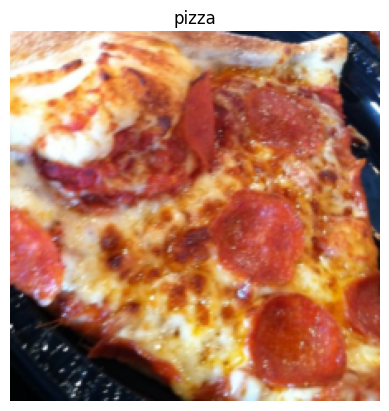

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

#output shape
emebedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 2D image flattened into patches): {emebedding_layer_output_shape}')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


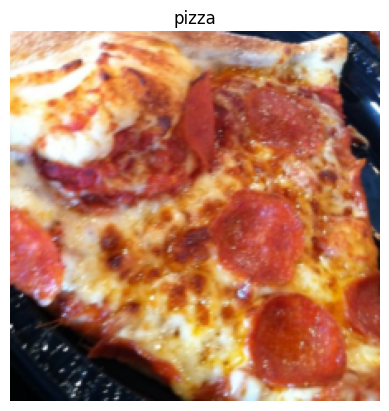

In [12]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

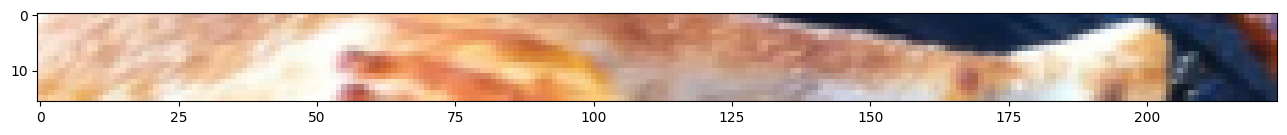

In [13]:
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of aptches per row: 14.0
Patch size: 16 pixels x 16 pixels


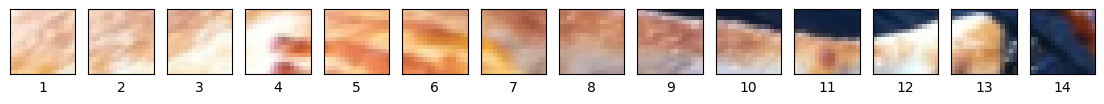

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(f'Number of aptches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

fig, axes = plt.subplots(nrows = 1,
                         ncols = img_size // patch_size,
                         figsize = (num_patches, num_patches),
                         sharex = True,
                         sharey = True)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axes[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

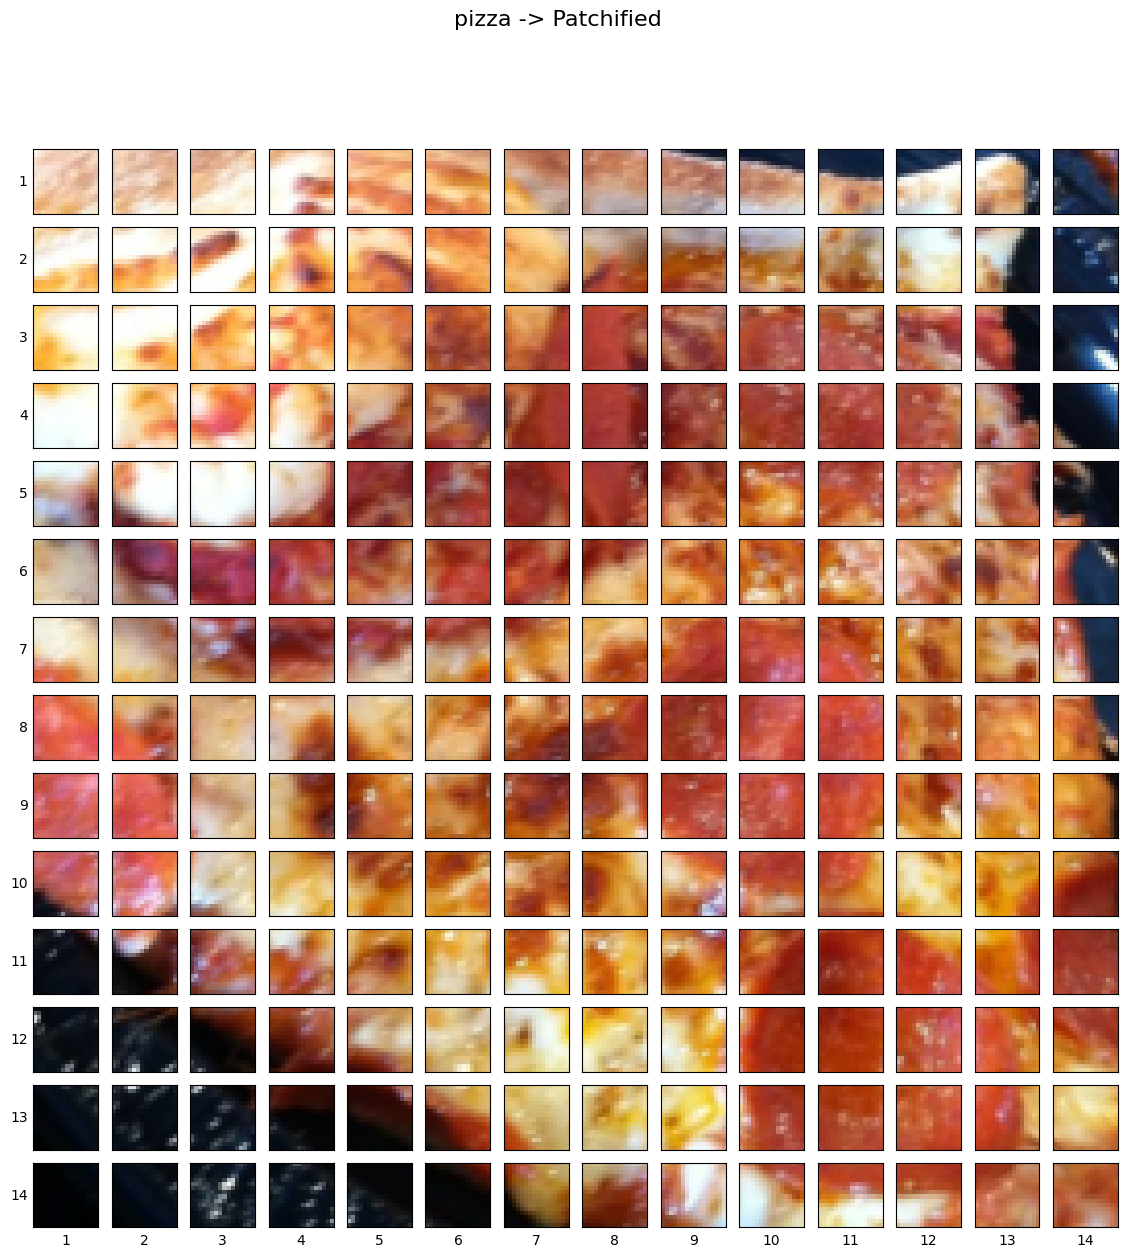

In [15]:
fig, axes = plt.subplots(nrows = img_size // patch_size,
                         ncols = img_size // patch_size,
                         figsize = (num_patches, num_patches),
                         sharex = True,
                         sharey = True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axes[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width : patch_width + patch_size,:])
    axes[i,j].set_ylabel(i+1,
                         rotation = 'horizontal',
                         horizontalalignment = 'right',
                         verticalalignment = 'center')
    axes[i,j].set_xlabel(j+1)
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    axes[i,j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchified', fontsize = 16)
plt.show()

In [16]:
patch_size = 16
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

In [17]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             )
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  def forward(self, x):
    image_res = x.shape[-1]
    assert image_res % patch_size == 0
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1)

In [18]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               attn_dropout: float = 0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True)
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_output

In [19]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [20]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,
               attn_dropout: float = 0):
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [21]:
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [22]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

In [23]:
summary(model = torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [24]:
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels: int = 3,
               patch_size: int = 16,
               num_transformer_layers: int = 12,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               num_heads: int = 12,
               attn_dropout: float = 0,
               mlp_dropout: float = 0.1,
               embedding_dropout: float = 0.1,
               num_classes: int = 1000):
    super().__init__()
    assert img_size % patch_size == 0

    self.num_patches = (img_size * img_size) // patch_size**2
    self.class_embedding = nn.Parameter(data = torch.randn(1,1, embedding_dim),
                                        requires_grad = True)
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim),
                                           requires_grad = True)
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim,
                                                                       num_heads = num_heads,
                                                                       mlp_size = mlp_size,
                                                                       mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim = 1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])
    return x

In [25]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.0937,  0.7612, -0.2205]], grad_fn=<AddmmBackward0>)

In [26]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [27]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr=3e-3,
                             betas = (0.9, 0.999),
                             weight_decay = 0.3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.9214 | train_acc: 0.2344 | test_loss: 2.3558 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.7078 | train_acc: 0.3828 | test_loss: 2.5580 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2672 | train_acc: 0.4219 | test_loss: 2.0553 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.3704 | train_acc: 0.2617 | test_loss: 1.6791 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2253 | train_acc: 0.2969 | test_loss: 1.3390 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1818 | train_acc: 0.2891 | test_loss: 1.2243 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1814 | train_acc: 0.4180 | test_loss: 1.3626 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1107 | train_acc: 0.3984 | test_loss: 1.1869 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1516 | train_acc: 0.4297 | test_loss: 1.0275 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2453 | train_acc: 0.2617 | test_loss: 1.3903 | test_acc: 0.2604


In [29]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [30]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

[INFO] data/pizza_steak_sushi directory exists, skipping download.


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [31]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [32]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [33]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176
